<a href="https://colab.research.google.com/github/Keachebet/tomato_leaf_disease_classification/blob/main/Copy_of_tomato_leaf_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
from google.colab import drive

In [4]:
drive.mount ('/content/drive')

Mounted at /content/drive


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/plantvillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4687 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(dataset)

147

In [8]:
147*32

4704

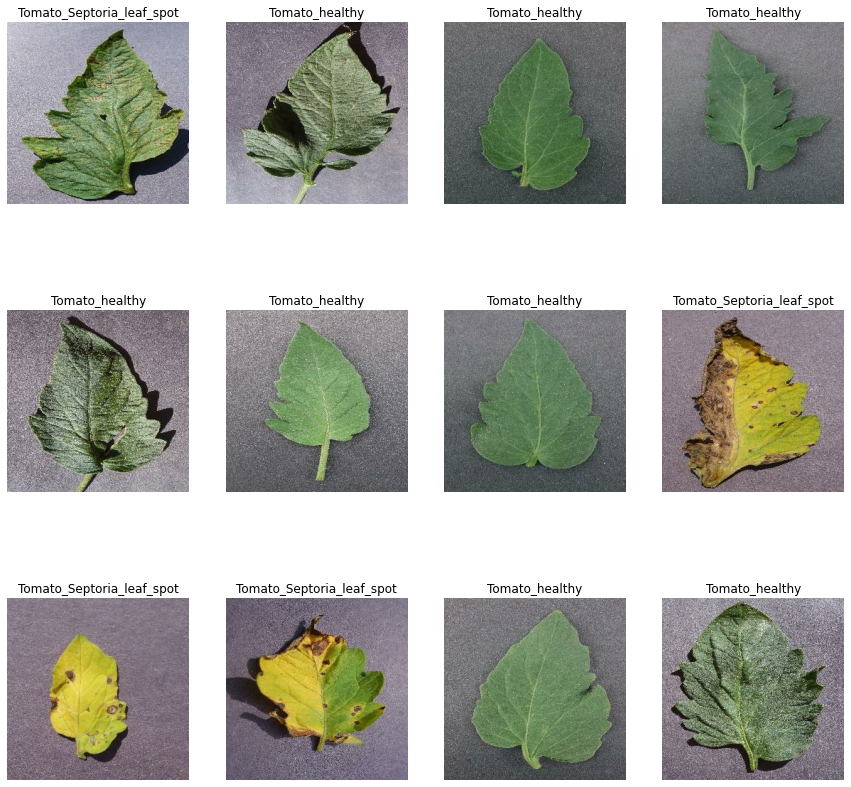

In [9]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataset.take(1):
  #print(image_batch.shape)
  #print(label_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [10]:
len(dataset)

147

In [11]:
train_size = 0.8
len(dataset)*train_size

117.60000000000001

In [12]:
train_ds = dataset.take(117)
len(train_ds)

117

In [13]:
test_ds = dataset.skip(117)
len(test_ds)

30

In [14]:
val_size = 0.1
len(dataset)*val_size

14.700000000000001

In [15]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [16]:
test_ds = test_ds.skip(14)
len(test_ds)

16

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

117

In [20]:
len(val_ds)

14

In [21]:
len(test_ds)

16

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
#encode = tf.one_hot(input_shape)
model.build(input_shape=input_shape)

In [34]:

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
117/117 [==============================] - 1296s 3s/step - loss: 1.1692 - accuracy: 0.4722 - val_loss: 0.9248 - val_accuracy: 0.6228
Epoch 2/10
117/117 [==============================] - 283s 2s/step - loss: 0.7812 - accuracy: 0.6871 - val_loss: 0.9271 - val_accuracy: 0.6451
Epoch 3/10
117/117 [==============================] - 284s 2s/step - loss: 0.7114 - accuracy: 0.6979 - val_loss: 0.6937 - val_accuracy: 0.6987
Epoch 4/10
117/117 [==============================] - 286s 2s/step - loss: 0.6198 - accuracy: 0.7424 - val_loss: 0.7005 - val_accuracy: 0.7076
Epoch 5/10
117/117 [==============================] - 285s 2s/step - loss: 0.5560 - accuracy: 0.7768 - val_loss: 0.5376 - val_accuracy: 0.7879
Epoch 6/10
117/117 [==============================] - 283s 2s/step - loss: 0.5303 - accuracy: 0.7805 - val_loss: 0.7836 - val_accuracy: 0.7344
Epoch 7/10
117/117 [==============================] - 284s 2s/step - loss: 0.4996 - accuracy: 0.8017 - val_loss: 1.1581 - val_accuracy: 0.647

In [37]:
scores = model.evaluate(test_ds)

16/16 [==============================] - 22s 745ms/step - loss: 0.5216 - accuracy: 0.8066


In [38]:
scores

[0.521571934223175, 0.806640625]

In [39]:
history

In [40]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 117}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

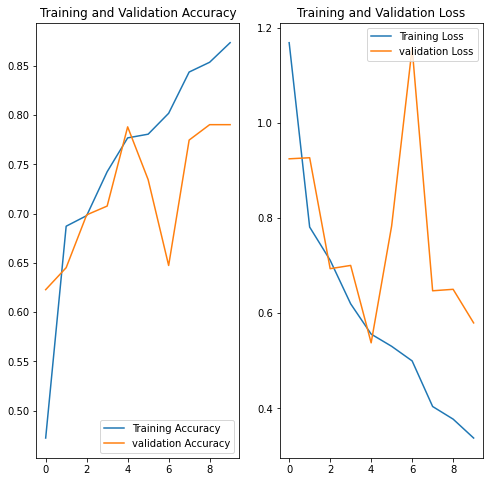

In [43]:
#plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
np.argmax([0.04968536, 0.89451694, 0.05579771])

1

first image to predict
actual label: Tomato_Leaf_Mold
1/1 [==============================] - 1s 767ms/step
predicted label: Tomato_Leaf_Mold


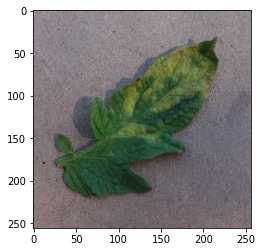

In [45]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])
  
  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])
     

In [46]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])), 2)
  return predicted_class, confidence


1/1 [==============================] - 0s 39ms/step


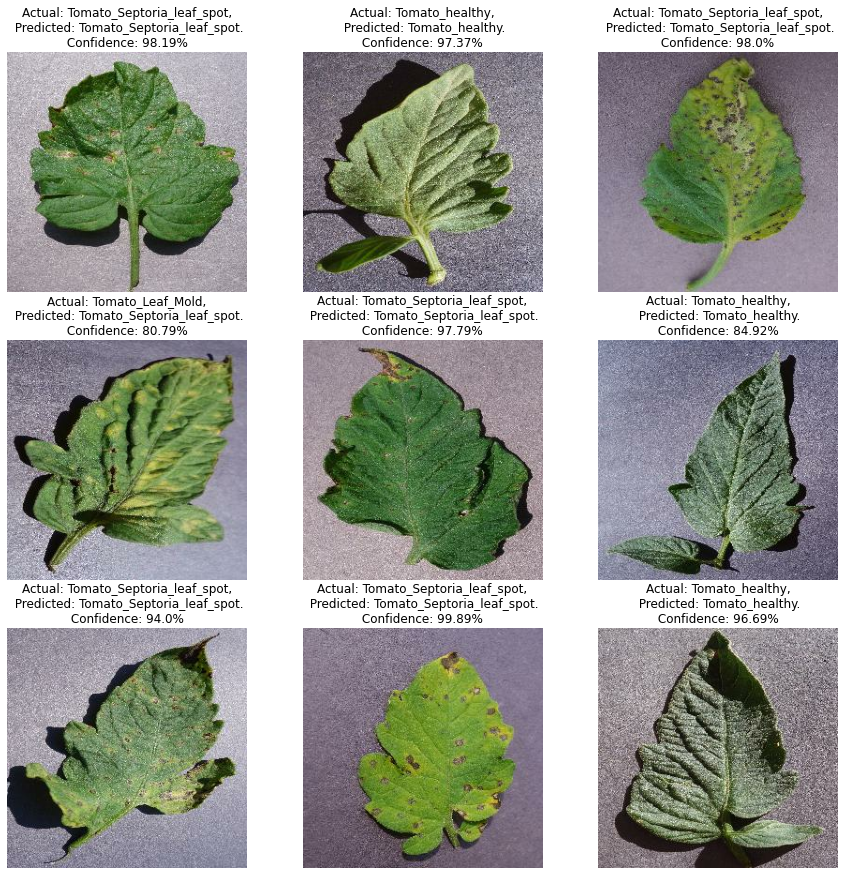

In [47]:
plt.figure(figsize= (15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}% ")

    plt.axis("off")

In [48]:
model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/tomato-disease/saved_models")+ [0]])+1
model.save(f"/content/drive/MyDrive/tomato-disease/saved_models{model_version}")